<a href="https://colab.research.google.com/github/Rimple-kumari/Breast-Cancer-Image-Classification-/blob/main/breast_cancer(minor_project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### I. Import Required Dependecies

In [2]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd             # Pandas
import numpy as np              # NumPy
import matplotlib.pyplot as plt # Matplotlib
import seaborn as sns           # Seaborn
from PIL import Image           # Pillow

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Keras
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import models, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
# Instead of:
# from keras.preprocessing.image import ImageDataGenerator

# Use:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input

# scikit-learn
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### II. Read Dataset

**Directory Names Containing Training Data**

In [5]:
# Define the path to the directory containing the images for training
train_data = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

# Create a Pandas DataFrame with a single column
# The column is populated with the list of file/directory names in the 'train_data' directory
pd.DataFrame(
    os.listdir(train_data),
    columns=['File Name']
)

,File Name
0,normal
1,benign
2,malignant


**Directory Paths Containing Training Data**

In [6]:
# Get a list of the file paths in the 'train_data' directory
train_files = [i for i in glob.glob(train_data + "/*/*")]

# Randomly shuffle the list of file paths
np.random.shuffle(train_files)

# Extract labels from the directory names of each file path
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]

# Combine file paths & its corresponding labels into a list of tuples
data = zip(train_files, labels)

# Create a Pandas DataFrame with 2 columns
# "Path" column contains file paths, & "Label" column contains corresponding labels
training_data = pd.DataFrame(data, columns=["Path", "Label"])

# Display the contents of the DataFrame
training_data

,Path,Label
0,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,normal
1,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
2,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
3,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
4,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant
...,...,...
1573,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
1574,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,normal
1575,/content/drive/MyDrive/Dataset_BUSI_with_GT/be...,benign
1576,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,malignant


### III. Data Visualization

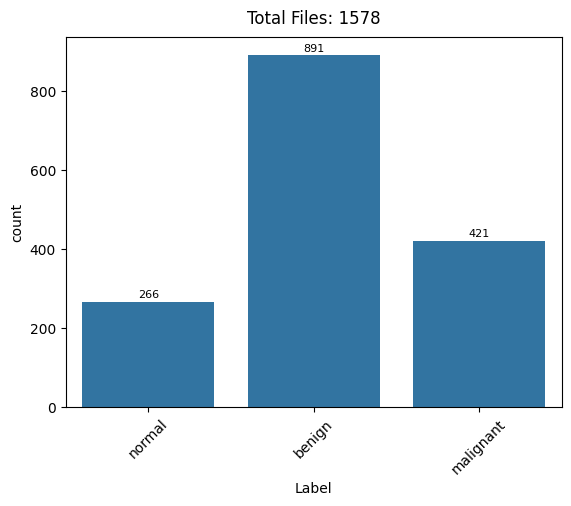

In [7]:
# Create a countplot() using Seaborn, where x-axis represents the "Label" column of the training_data DataFrame
ax = sns.countplot(x=training_data["Label"])

# Display count inside each bar as integers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title with the total count of files
plt.title(f'Total Files: {len(training_data)}', pad=10)

# Show the plot
plt.show()

### IV. Collect Data Paths & Labels from Directory Structure

In [8]:
data_paths = []
labels = []

main_dirs = os.listdir(train_data)
for folder_name in main_dirs:
    folder_path = os.path.join(train_data, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

### V. Data Preprocessing

In [9]:
# Set the batch size for training
batch_size = 16

# Define the target image size for preprocessing
image_size = (256, 256)

# Specify the number of color channels in the images (3 for RGB)
num_channels = 3

# Create the image shape tuple based on the specified size and channels
image_shape = (image_size[0], image_size[1], num_channels)

# Create a Pandas Series containing file paths with the name 'Path'
data_dirs = pd.Series(data_paths, name='Path')

# Create a Pandas Series containing corresponding labels with the name 'Label'
classes = pd.Series(labels, name='Label')

def preprocess_image(img):
    return img

# Split the data into training and validation-test sets
train_df, val_test_df = train_test_split(
    training_data,
    train_size=0.8,
    shuffle=True,
    random_state=123
)

# Further split the validation-test set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df,
    train_size=0.5,
    shuffle=True,
    random_state=123
)

# ImageDataGenerator configuration
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1.0/255
)

# Convert the 'Label' column to string type
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

# Create generators for training, validation, and testing
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.


**Display Class Names**

In [10]:
# Get the class indices (mapping of the class names to numerical indices) from the training generator
class_indices = train_generator.class_indices

# Display the keys (class names) from the class_indices dictionary
class_indices.keys()

dict_keys(['benign', 'malignant', 'normal'])

In [11]:
# Initialize an empty list to store class labels
labels = []

# Iterate through the keys (class names) in the class_indices dictionary
for key in class_indices.keys():
    labels.append(key)  # Append each class name to the labels list

# Calculate the total no. of unique labels
total_labels = len(labels)

# Print the list of class labels and the total no. of unique labels
print("Labels: ", labels)
print("\nTotal no. of unique labels:", total_labels)

Labels:  ['benign', 'malignant', 'normal']

Total no. of unique labels: 3


**Visualize a Subset of Images from the Training Set**

(477, 509, 3)
(473, 323)
(496, 549)
(466, 561, 3)
(459, 569)
(458, 551)
(473, 562)
(470, 558, 3)


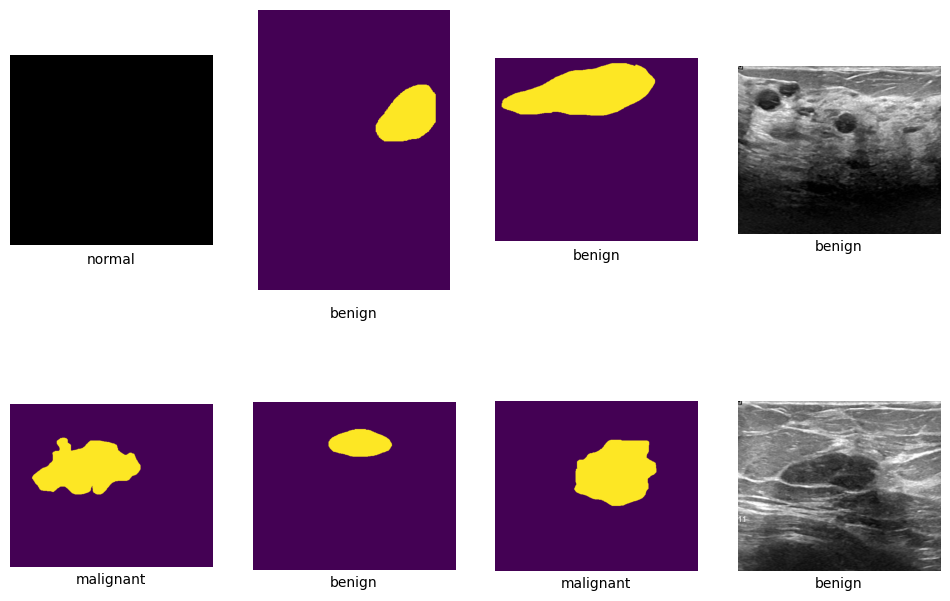

In [12]:
# Set the number of rows and columns for the subplot grid
no_of_rows = 2
no_of_columns = 4

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(12, 8))

# Iterate through the rows
for i in range(no_of_rows):
    # Iterate through the columns
    for j in range(no_of_columns):
        # Calculate the index for accessing the data
        index = i * no_of_columns + j

        # Check if the index is within the bounds of the data
        if index < len(training_data):

            # Open the image using the PIL library
            im = Image.open(training_data.iloc[index]['Path'])

            # Convert the PIL image to a NumPy array
            img = np.array(im)

            # Print the shape of the image array
            print(img.shape)

            # Display the image on the subplot at position (i, j)
            axes[i, j].imshow(img)

            # Turn off axis labels for better visualization
            axes[i, j].axis('off')

            # Get the label for the current image and display it as text
            label = training_data.iloc[index]['Label']
            axes[i, j].text(0.5, -0.1, label, ha='center', transform=axes[i, j].transAxes)

# Show the entire subplot grid
plt.show()

### VI. Build Model

In [13]:
# Load DenseNet-121 with pre-trained weights
base_model = DenseNet121(
    weights='/content/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create model
model = Sequential()

# Add the pre-trained DenseNet-121 base model
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout for regularization
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

# Additional layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Display the summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,787,843 (289.11 MB)

 Trainable params: 68,750,339 (262.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Visualize the Neural Network Architecture**

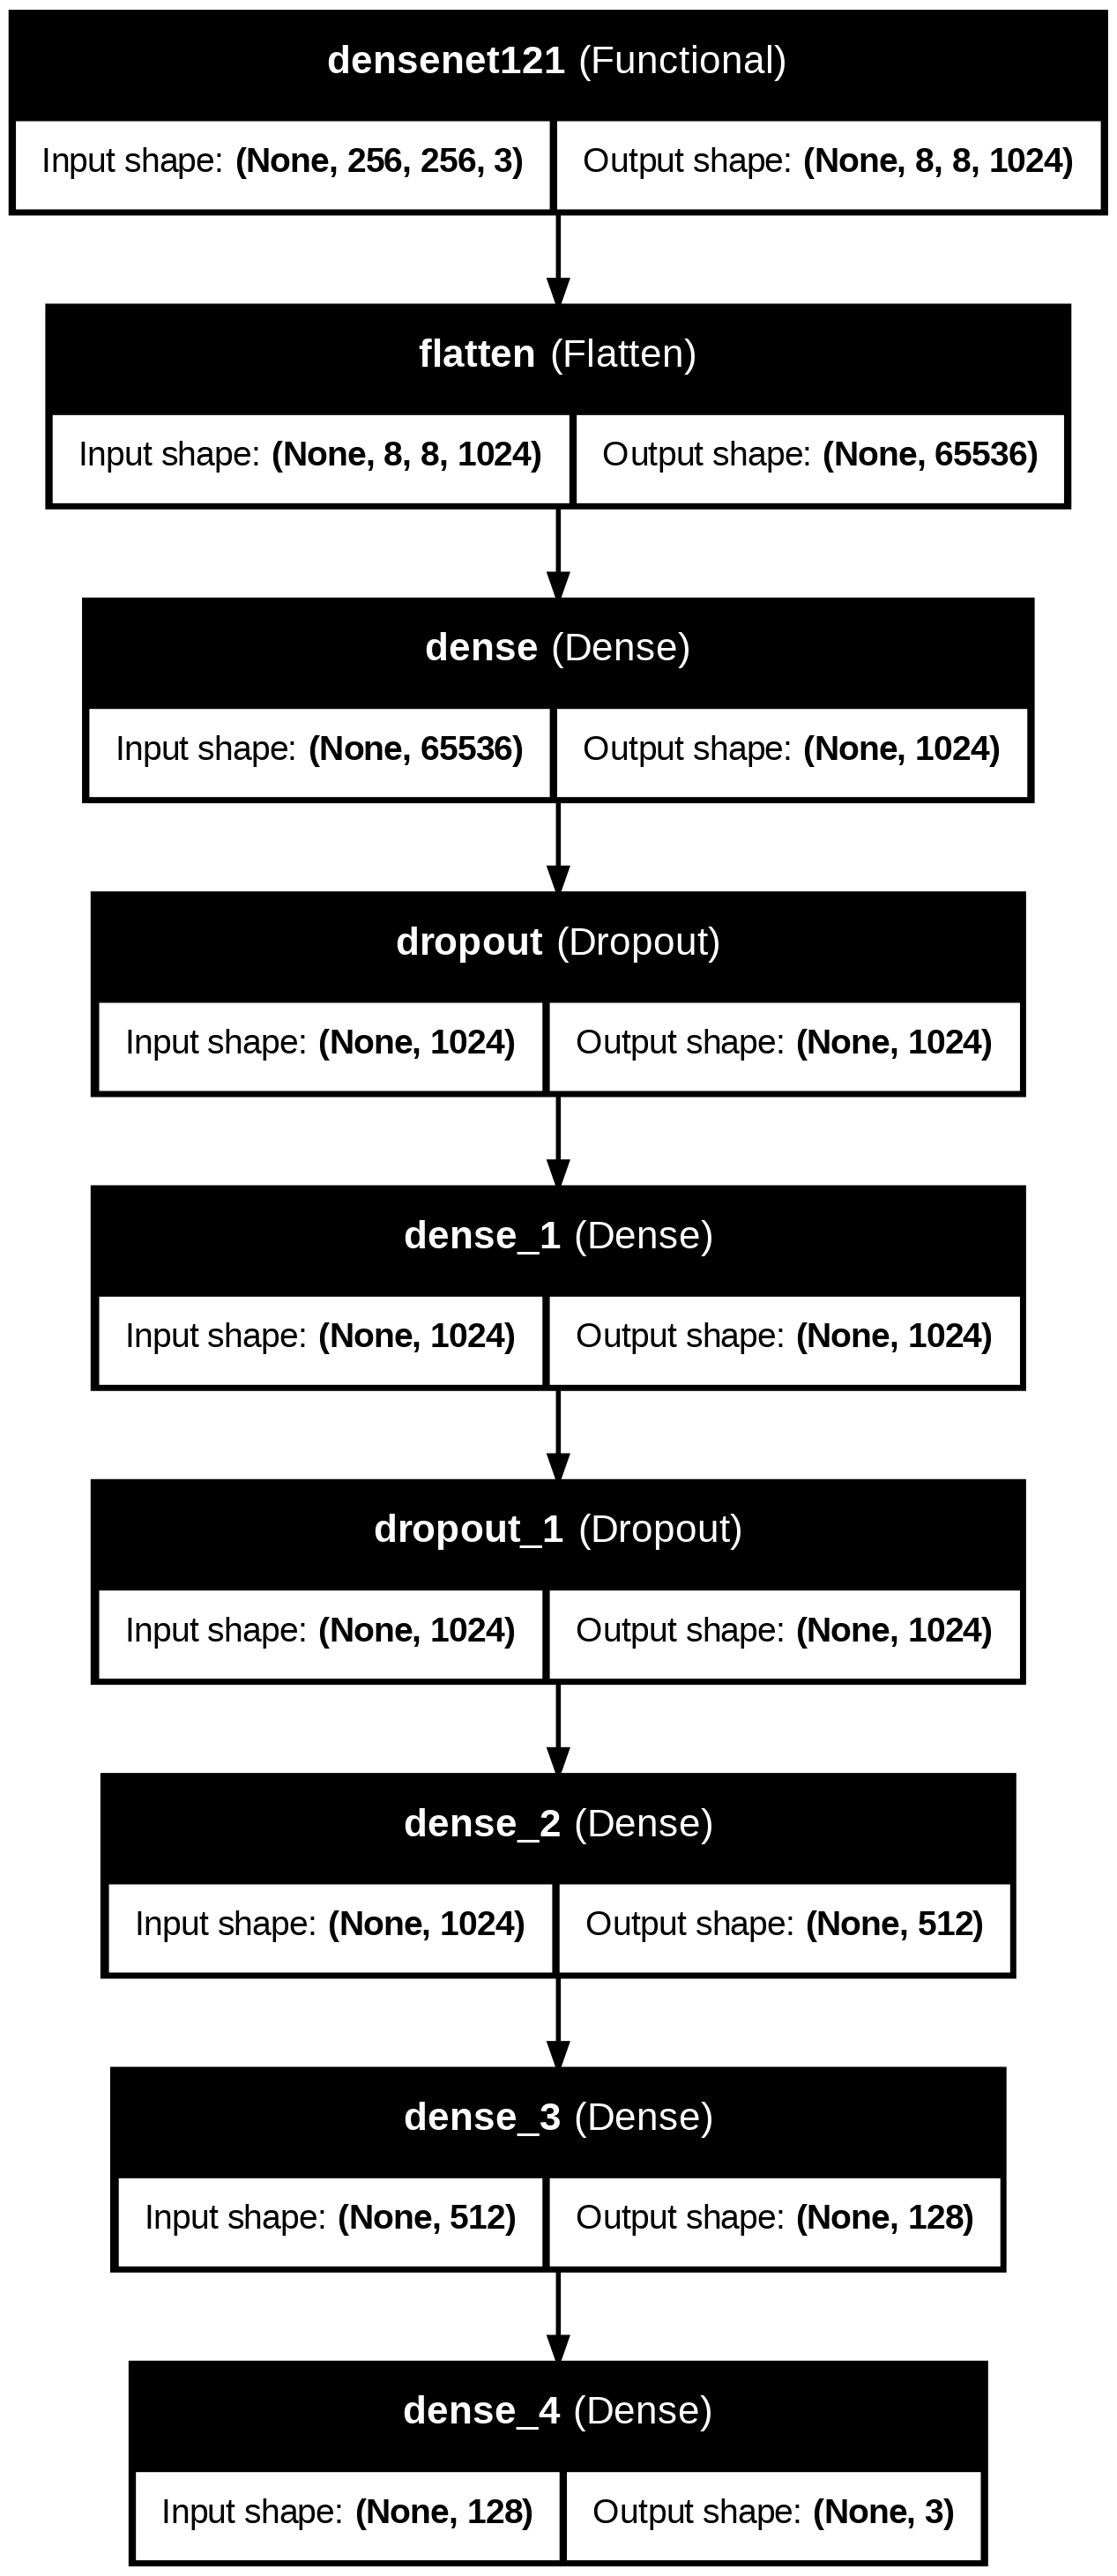

In [14]:
import os

# ... (rest of your imports and code) ...

# Specify the file path for saving the visualization image
model_visualization_path = "nn_architecture.png"  # Changed path

# Create the directory if it doesn't exist
# Check if the path has a directory component before creating directories
if os.path.dirname(model_visualization_path):
    os.makedirs(os.path.dirname(model_visualization_path), exist_ok=True)

# Plot the model and save the visualization image
plot_model(model, to_file=model_visualization_path, show_shapes=True, show_layer_names=True)

# Display the visualization image
IPImage(filename=model_visualization_path)

**Create Model Checkpoint Callback to Save Best Model**

In [15]:
# Define the path to save the best model checkpoint
checkpoint_path = "/kaggle/working/model.h5"

# Create a ModelCheckpoint callback
# This callback saves the model when validation accuracy improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',              # Save based on the maximum validation accuracy
    verbose=1                # Display progress information
)

### VII. Compile Model

In [16]:
# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Categorical crossentropy loss for multi-class classification
    metrics=['accuracy']              # Monitor accuracy during training
)

### VIII. Train Model

In [17]:
# Train the model using the fit() method
history = model.fit(
    train_generator,                                   # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    epochs=10,                                         # Number of training epochs
    validation_data=valid_generator,                   # Validation data generator
    validation_steps=valid_generator.samples // valid_generator.batch_size,  # Number of validation steps
    callbacks=[checkpoint]                             # List of callbacks, including the ModelCheckpoint
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6013 - loss: 6.9639
Epoch 1: val_accuracy improved from -inf to 0.81944, saving model to /kaggle/working/model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.6020 - loss: 6.9266 - val_accuracy: 0.8194 - val_loss: 0.6610
Epoch 2/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 7:14 6s/step - accuracy: 0.9375 - loss: 0.0946

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.81944
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 821ms/step - accuracy: 0.9375 - loss: 0.0946 - val_accuracy: 0.7917 - val_loss: 0.6679
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7722 - loss: 0.7721
Epoch 3: val_accuracy did not improve from 0.81944
78/78 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.7722 - loss: 0.7714 - val_accuracy: 0.7639 - val_loss: 0.4820
Epoch 4/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5:56 5s/step - accuracy: 0.7500 - loss: 0.6345
Epoch 4: val_accuracy did not improve from 0.81944
78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 416ms/step - accuracy: 0.7500 - loss: 0.6345 - val_accuracy: 0.7847 - val_loss: 0.4537
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8236 - loss: 0.4537
Epoch 5: val_accuracy improved from 0.81944 to 0.89583, saving model to /kaggle/working/model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 455s 6s/step - accuracy: 0.8238 - loss: 0.4534 - val_accuracy: 0.8958 - val_loss: 0.2756
Epoch 6/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 7:56 6s/step - accuracy: 0.8125 - loss: 0.3187
Epoch 6: val_accuracy improved from 0.89583 to 0.90278, saving model to /kaggle/working/model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 76s 904ms/step - accuracy: 0.8125 - loss: 0.3187 - val_accuracy: 0.9028 - val_loss: 0.2777
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8584 - loss: 0.3500
Epoch 7: val_accuracy did not improve from 0.90278
78/78 ━━━━━━━━━━━━━━━━━━━━ 434s 5s/step - accuracy: 0.8583 - loss: 0.3502 - val_accuracy: 0.8264 - val_loss: 0.4348
Epoch 8/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 7:04 6s/step - accuracy: 0.7500 - loss: 0.6629
Epoch 8: val_accuracy did not improve from 0.90278
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 562ms/step - accuracy: 0.7500 - loss: 0.6629 - val_accuracy: 0.8542 - val_loss: 0.4001
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8932 - loss: 0.3089
Epoch 9: val_accuracy did not improve from 0.90278
78/78 ━━━━━━━━━━━━━━━━━━━━ 494s 6s/step - accuracy: 0.8931 - loss: 0.3090 - val_accuracy: 0.8403 - val_loss: 0.4048
Epoch 10/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - accuracy: 0.7500 - loss: 0.4971
Epoch 10: val_accuracy did not improve fro

**Display Training History**

In [18]:
# Create a Pandas DataFrame containing the training history (metrics) of the model
train_history = pd.DataFrame(history.history)

# Add a new column 'Epoch' with values from 1 to the number of epochs
train_history['Epoch'] = range(1, len(train_history) + 1)

# Reorder columns for clarity
train_history = train_history[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Display the DataFrame
train_history

,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,4.017467,0.655698,0.661050,0.819444
1,2,0.094599,0.937500,0.667921,0.791667
2,3,0.717814,0.776886,0.482021,0.763889
3,4,0.634450,0.750000,0.453724,0.784722
4,5,0.428292,0.837079,0.275595,0.895833
5,6,0.318713,0.812500,0.277714,0.902778
6,7,0.365486,0.857945,0.434781,0.826389
7,8,0.662865,0.750000,0.400100,0.854167
8,9,0.317671,0.886838,0.404841,0.840278
9,10,0.497116,0.750000,0.452998,0.840278


### IX. Evaluate Model (Train & Validation Set)

In [19]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)

# Convert accuracy to percentage
train_accuracy_percentage = train_accuracy * 100
val_accuracy_percentage = val_accuracy * 100

# Create a Pandas DataFrame to display the results
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [f'{train_accuracy_percentage:.2f}%', f'{val_accuracy_percentage:.2f}%']
})

# Display the evaluation results DataFrame
evaluation_results

78/78 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.9291 - loss: 0.1922
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.8386 - loss: 0.4838


,Set,Loss,Accuracy
0,Train,0.200208,93.03%
1,Validation,0.425463,84.72%


**Plot Loss & Accuracy**

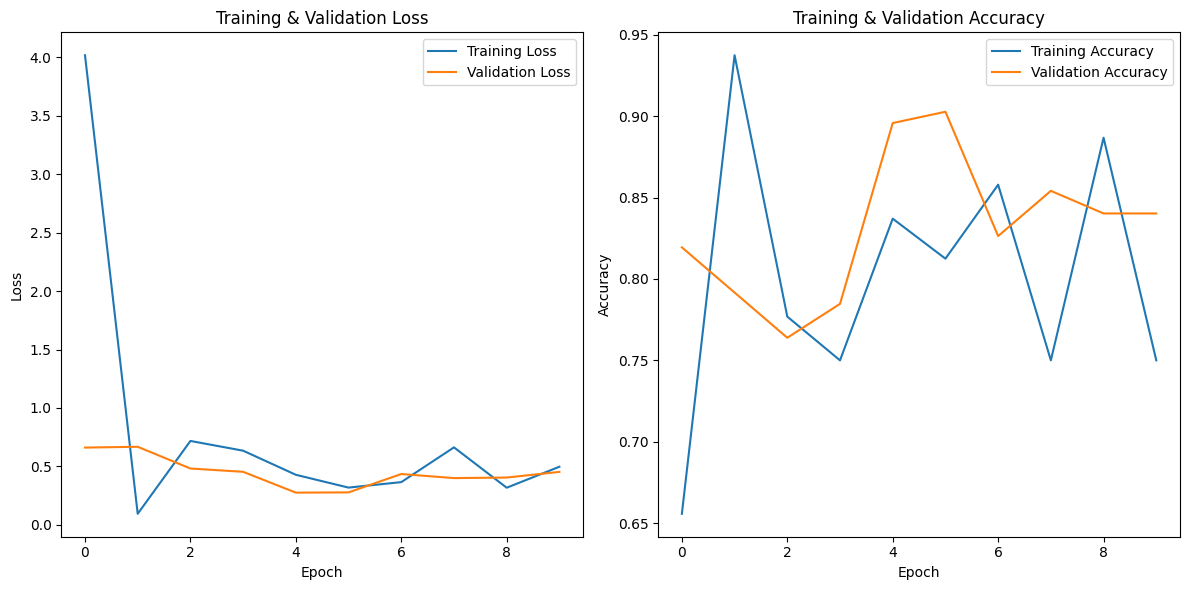

In [22]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Evaluation model

In [20]:
import pandas as pd             # Pandas
import numpy as np              # NumPy
import matplotlib.pyplot as plt # Matplotlib
import seaborn as sns           # Seaborn

# scikit-learn
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow with Keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed import to use tensorflow.keras
from tensorflow.keras.preprocessing import image # Changed import to use tensorflow.keras

In [21]:
import pandas as pd             # Pandas
import numpy as np              # NumPy
import matplotlib.pyplot as plt # Matplotlib
import seaborn as sns           # Seaborn

# scikit-learn
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow with Keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed import to use tensorflow.keras
from tensorflow.keras.preprocessing import image # Changed import to use tensorflow.keras

# ... (your previous code for model training and data preprocessing) ...

# Set the path to the directory containing the test images
test_data_path = '/content/drive/MyDrive/test_images'

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create a generator for the test data
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test set using the existing 'model' object
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 158 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9019 - loss: 0.3423
Test Loss: 0.38737380504608154
Test Accuracy: 0.8797468543052673


In [23]:
# Convert accuracy to percentage
test_accuracy_percentage = test_accuracy * 100

# Create a Pandas DataFrame to display the result
evaluation_result = pd.DataFrame({
    'Set': ['Test'],
    'Loss': [test_loss],
    'Accuracy': [f'{test_accuracy_percentage:.2f}%']
})

# Display the evaluation result DataFrame
evaluation_result

,Set,Loss,Accuracy
0,Test,0.387374,87.97%


10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step


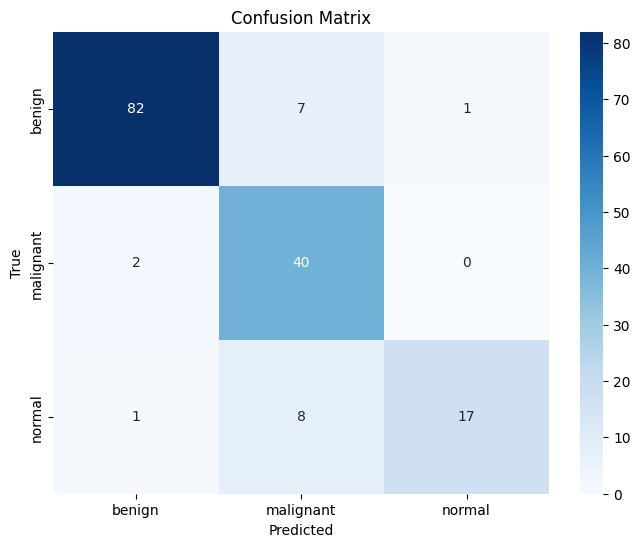

              precision    recall  f1-score   support

      benign       0.96      0.91      0.94        90
   malignant       0.73      0.95      0.82        42
      normal       0.94      0.65      0.77        26

    accuracy                           0.88       158
   macro avg       0.88      0.84      0.84       158
weighted avg       0.90      0.88      0.88       158



In [25]:
# Define class names
class_names = ['benign', 'malignant', 'normal']

# Generate predictions for the test set using the existing 'model' object
predictions = model.predict(test_generator)  # Use 'model' instead of 'loaded_model'
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(class_report)

In [26]:
# Display the overall accuracy
print(f"Overall Accuracy: {test_accuracy_percentage:.2f}%")

Overall Accuracy: 87.97%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Real Class: benign
Predicted Class: benign
"Correct"



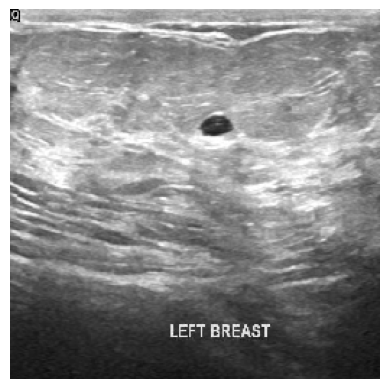

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Real Class: benign
Predicted Class: benign
"Correct"



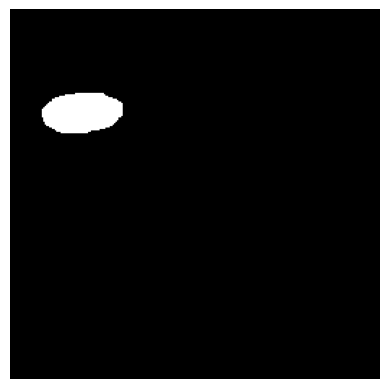

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Real Class: malignant
Predicted Class: malignant
"Correct"



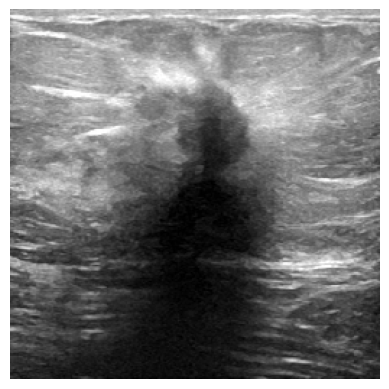

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Real Class: normal
Predicted Class: normal
"Correct"



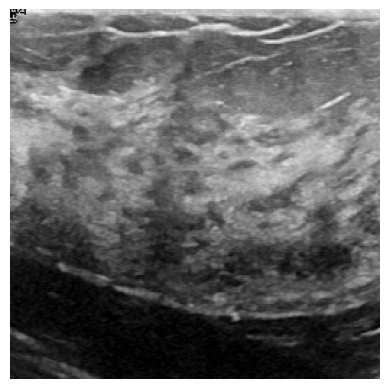

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Real Class: normal
Predicted Class: normal
"Correct"



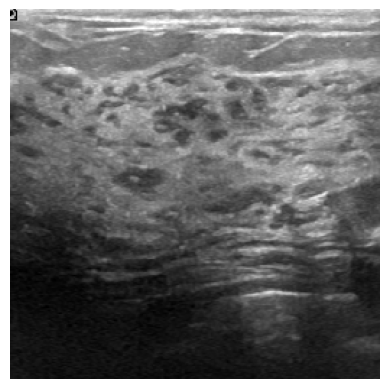

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Real Class: malignant
Predicted Class: malignant
"Correct"



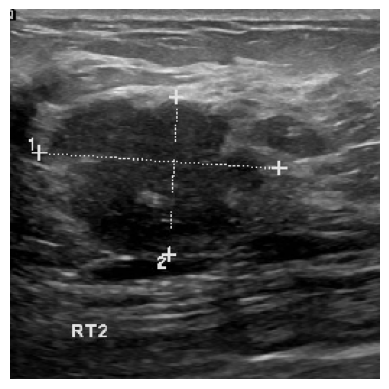


 6 out of 6 images are classified correctly.


In [31]:
# Define a list of image paths you want to classify
image_paths = [
    '/content/drive/MyDrive/test_images/benign/benign (1).png',
    '/content/drive/MyDrive/test_images/benign/benign (100)_mask_1.png',
    '/content/drive/MyDrive/test_images/malignant/malignant (104).png',
    '/content/drive/MyDrive/test_images/normal/normal (11).png',
    '/content/drive/MyDrive/test_images/normal/normal (125).png',
    '/content/drive/MyDrive/test_images/malignant/malignant (111).png',
]

# Initialize a counter for correct predictions
correct_predictions = 0

# Loop through each image path
for image_path in image_paths:
    # Extract the real class from the image path or any other source
    real_class = image_path.split('/')[-2]  # Adjust the split based on your directory structure

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale pixel values to [0, 1]

    # Make predictions using the existing 'model' variable
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_label_index = np.argmax(predictions)

    # Map the predicted class index to the actual class label (if you have a mapping)
    class_labels = {0: 'benign', 1: 'malignant', 2: 'normal'}  # Update with your actual class labels
    predicted_label = class_labels.get(predicted_label_index, 'Unknown')

    # Check correctness
    correctness = '"Correct"' if real_class == predicted_label.lower() else '"Incorrect"'

    # Display the real class, predicted class, and correctness
    print(f'Real Class: {real_class}')
    print(f'Predicted Class: {predicted_label}')
    print(correctness)
    print()

    # Increment the correct predictions counter
    if correctness == '"Correct"':
        correct_predictions += 1

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels for better visualization
    plt.show()

# Display the overall correctness
print(f'\n {correct_predictions} out of {len(image_paths)} images are classified correctly.')